<a href="https://colab.research.google.com/github/Muriloide21/PosGrad-AI-MachineLearning/blob/main/aula6b_%C3%81rvores_de_decis%C3%A3o_atributos_cont%C3%ADnuos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Árvore de decisão para atributos contínuos

In [174]:
# from sklearn.datasets import load_iris
# dataset = load_iris()
# X, y = dataset.data, dataset.target

from sklearn.datasets import load_breast_cancer

# Carregar o conjunto de dados de câncer de mama
dataset = load_breast_cancer()
X, y = dataset.data, dataset.target

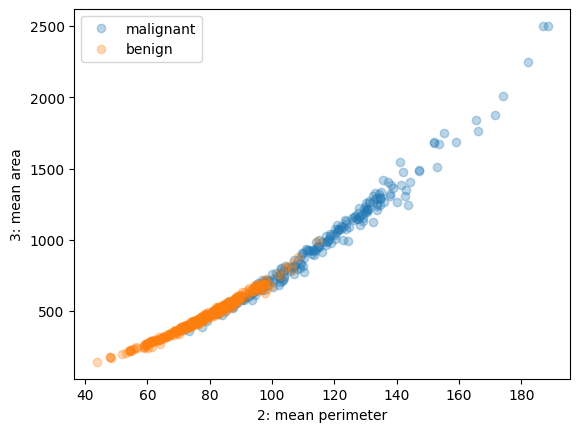

In [175]:
import matplotlib.pyplot as plt
i, j = 2, 3
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")

for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], 'o', alpha=0.3,
           label=f"{dataset.target_names[k]}")
plt.legend()
plt.show()

In [176]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np
from sklearn.model_selection import cross_validate

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class ZeroR(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    y[:] = self.resposta
    return y

scores = cross_validate(ZeroR(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.62280702, 0.62280702, 0.63157895, 0.63157895, 0.62831858]),
 0.6274181027790716)

In [177]:
modelo = ZeroR()
modelo.fit(X, y)
modelo.resposta

1

In [178]:
modelo = ZeroR()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.6274165202108963

In [179]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica = 2
    self.valor = np.mean(X[:,self.caracteristica])
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.9876977152899824

In [180]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.8245614 , 0.79824561, 0.85087719, 0.85964912, 0.84070796]),
 0.8348082595870207)

In [181]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i, k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades ** 2)
  return result

impureza(y[:])

0.4675300607546925

In [182]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezamaiores = impureza(y[maiores])
  proporcaomaiores = sum(maiores)/len(y)
  impurezamenores = impureza(y[~maiores])
  proporcaomenores = sum(~maiores)/len(y)
  impurezaTotal = proporcaomaiores*impurezamaiores + proporcaomenores*impurezamenores
  return impurezaTotal, impurezamenores, impurezamaiores

impurezaValor(X[:,2], y, 2.5)

(0.4675300607546925, 1, 0.4675300607546925)

In [183]:
def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    valor = (xmin+xmax)/2
    impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor
      if impMaiores == 0 or impMenores == 0:
        break
      if impMaiores < impMenores:
        xmin = valor
      else:
        xmax = valor
    else:
      break
  return result, menorImpureza

melhorValor(X[:,2], y)

(116.145, 0.30371755118489246)

In [184]:
def melhorValorModificado(x, y):
    result = None
    menorImpureza = float('inf')

    # Ordena as instâncias pelo valor da característica
    sorted_indices = np.argsort(x)
    sorted_x = x[sorted_indices]
    sorted_y = y[sorted_indices]

    for i in range(len(x) - 1):
        valor = (sorted_x[i] + sorted_x[i + 1]) / 2
        impTotal, _, _ = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor

    return result, menorImpureza

In [185]:
print(melhorValor(X[:,2], y))
print(melhorValorModificado(X[:,2], y))

(116.145, 0.30371755118489246)
(98.755, 0.1916093835208614)


In [186]:
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  # print(impurezas)
  # print(valores)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

def melhorCaracteristicaModificada(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValorModificado(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

print(melhorCaracteristica(X, y))
print(melhorCaracteristicaModificada(X, y))

(0.1504971683890802, 27, 0.1455)
(0.14231918091829165, 20, 16.795)


In [187]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    if self.caracteristica is None or self.valor is None:
      self.resposta = maisFrequente(y)
      return self
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

class ArvoreModificada(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristicaModificada(X, y)
    if self.caracteristica is None or self.valor is None:
      self.resposta = maisFrequente(y)
      return self
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
print(sum(y==ypred)/len(y))

modelo = ArvoreModificada()
modelo.fit(X, y)
ypred = modelo.predict(X)
print(sum(y==ypred)/len(y))

1.0
1.0


In [188]:
scores = cross_validate(Arvore(), X, y)
print(scores['test_score'], np.mean(scores['test_score']))

scores = cross_validate(ArvoreModificada(), X, y)
print(scores['test_score'], np.mean(scores['test_score']))

[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
[0.88596491 0.90350877 0.92982456 0.93859649 0.92920354] 0.9174196553330228


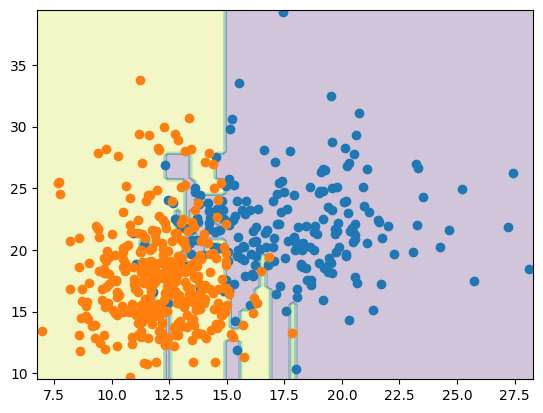

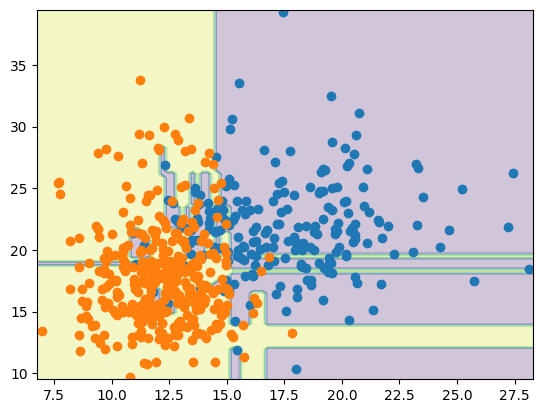

In [189]:
plotDecisao(Arvore(), X[:,:2], y)
plotDecisao(ArvoreModificada(), X[:,:2], y)

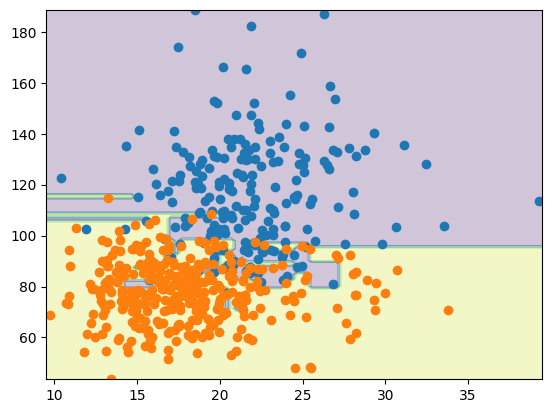

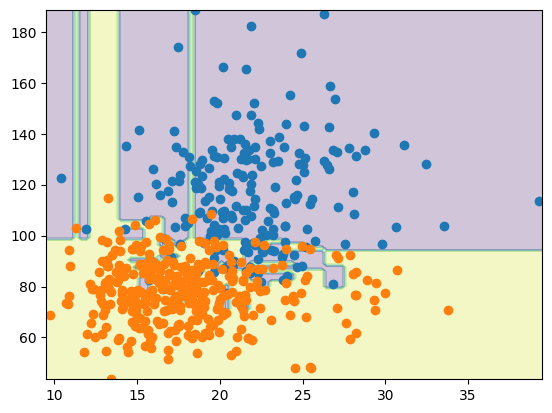

In [190]:
plotDecisao(Arvore(), X[:,1:3], y)
plotDecisao(ArvoreModificada(), X[:,1:3], y)

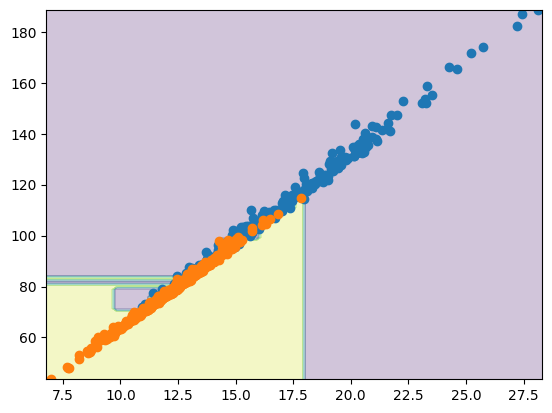

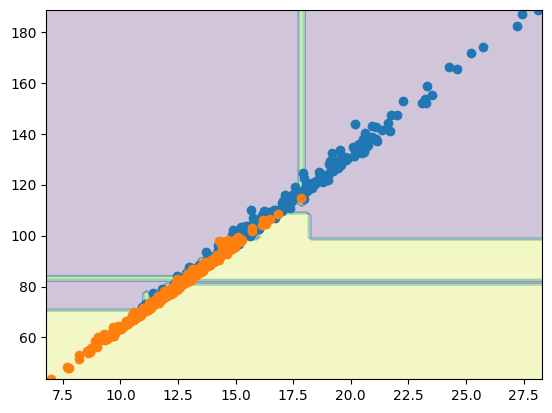

In [191]:
plotDecisao(Arvore(), X[:,[0,2]], y)
plotDecisao(ArvoreModificada(), X[:,[0,2]], y)

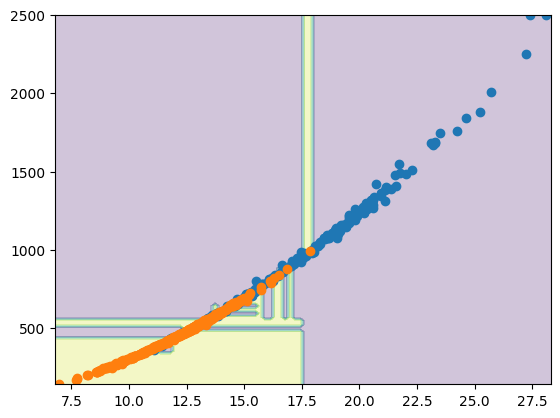

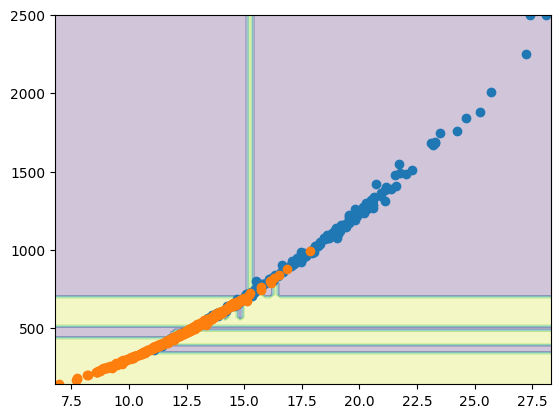

In [192]:
plotDecisao(Arvore(), X[:,[0,3]], y)
plotDecisao(ArvoreModificada(), X[:,[0,3]], y)

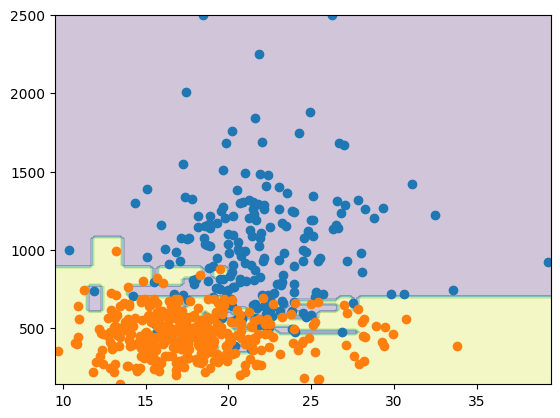

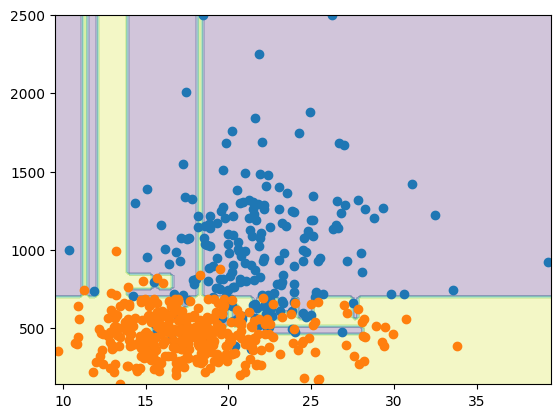

In [193]:
plotDecisao(Arvore(), X[:,[1,3]], y)
plotDecisao(ArvoreModificada(), X[:,[1,3]], y)